# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
import cv2
import random
import numpy as np
import pandas as pd
import pickle

from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Загружаем разметку

In [2]:
import os
import json
from glob import glob
import re


TRAIN_PREFIX = '../input/the-nature-conservancy-fisheries-monitoring/train'

def load_boxes():
    boxes = dict()
    for path in glob('../input/fishnetology/boxes/*'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            boxes[label] = json.load(src)
            for annotation in boxes[label]:
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
            for annotation in boxes[label]:
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
    boxes['other'] = []                
    class_name = 'image'
    for path in glob('../input/other-fish/other/img*'):
            annotation = []
            filename = path.split('/')[-1].split('.')[-2]
            filename = os.path.join(TRAIN_PREFIX, 'OTHER', filename+'.jpg')
            img = cv2.imread(filename, cv2.IMREAD_COLOR)[...,::-1]
            height, width, _ = img.shape 
            with open(path, 'r') as f:
                for s in f:
                    obj_cls,x,y,w,h = s.split(' ')
                    #print('o',obj_cls,'x',x,'y',y,'w',w,'h',h)
                    annotation.append({'class':'rect',
                                          'x': float(width)*float(x),
                                          'y': float(height)*float(y),
                                          'height': float(height)*float(h),
                                          'width': float(width)*float(w)})
                    #print(annotation)
            boxes['other'].append({'annotations': annotation,
                                       'class': class_name,
                                       'filename': filename})     
  
    boxes['nof'] = []     
    path_NoF  = os.path.join(TRAIN_PREFIX, 'NoF', '*')
    for path in glob(path_NoF):
        boxes['nof'].append({'annotations': [],
                             'class': class_name,
                             'filename': path})
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None, img=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    if img is None:
        img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, tuple(image_size))
        
    img = _draw(img, annotation['annotations'], scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [3]:
boxes = load_boxes()  # разметка детекций

In [4]:
boxes.keys()

dict_keys(['dol', 'shark', 'bet', 'lag', 'yft', 'alb', 'other', 'nof'])

In [5]:
boxes['other'][4:7]

[{'annotations': [{'class': 'rect',
    'x': 975.4995200000001,
    'y': 460.49976000000004,
    'height': 240.99984,
    'width': 519.00032}],
  'class': 'image',
  'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/OTHER/img_04652.jpg'},
 {'annotations': [{'class': 'rect',
    'x': 759.00032,
    'y': 282.49992000000003,
    'height': 168.99983999999998,
    'width': 502.00064}],
  'class': 'image',
  'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/OTHER/img_05345.jpg'},
 {'annotations': [{'class': 'rect',
    'x': 819.00032,
    'y': 282.00023999999996,
    'height': 123.99983999999999,
    'width': 496.0}],
  'class': 'image',
  'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/OTHER/img_04779.jpg'}]

In [6]:
# Выведем картинки с отсутствующей разметкой (кроме картинок с примерами отсутствия рыб)
for key in boxes.keys():
    for i in range(len(boxes[key])):
        if key != 'nof' and len(boxes[key][i]['annotations']) == 0:
            print(key,i,boxes[key][i])
           
print('stop') 



dol 9 {'annotations': [], 'class': 'image', 'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/DOL/img_06773.jpg'}
dol 36 {'annotations': [], 'class': 'image', 'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/DOL/img_05444.jpg'}
shark 42 {'annotations': [], 'class': 'image', 'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/SHARK/img_06082.jpg'}
bet 191 {'annotations': [], 'class': 'image', 'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/BET/img_00379.jpg'}
yft 306 {'annotations': [], 'class': 'image', 'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/YFT/img_04558.jpg'}
yft 434 {'annotations': [], 'class': 'image', 'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/YFT/img_03183.jpg'}
yft 476 {'annotations': [], 'class': 'image', 'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/YFT/img_02785.jpg'}
alb 239 {'annotations': [], 'class

In [7]:
pd.DataFrame([(k, len(v)) for k, v in boxes.items()],
             columns=['class', 'count'])

,class,count
0,dol,117
1,shark,176
2,bet,200
3,lag,67
4,yft,734
5,alb,1719
6,other,295
7,nof,465


In [9]:
# удалим картинки с ошибочной разметкой и с отсутствующей разметкой

import copy
boxes['dol'][9]['annotations'] = copy.deepcopy(boxes['dol'][37]['annotations'])
boxes['dol'][9]['annotations'][0]['x'] -= 20
boxes['dol'][9]['annotations'][0]['y'] -= 15
boxes['dol'][9]['annotations'][0]['width'] += 50
boxes['dol'][9]['annotations'][0]['height'] += 30

for key in boxes.keys():
    for i in range(len(boxes[key])-1, -1, -1):
        if key != 'nof' and len(boxes[key][i]['annotations']) == 0:
            boxes[key].pop(i)


for i in range(len(boxes['alb'])-1,-1,-1):
    if boxes['alb'][i]['filename'].split('/')[-1] == 'img_07212.jpg':
        boxes['alb'].pop(i)

for i in range(len(boxes['dol'])-1,-1,-1):
    if boxes['dol'][i]['filename'].split('/')[-1] == 'img_07212.jpg':
        boxes['dol'].pop(i)

### Распределение размеров разметки

0.0 1.00008


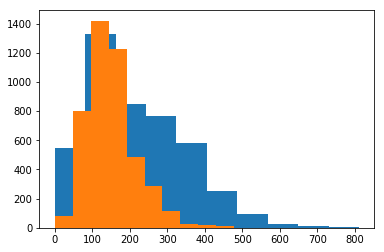

In [10]:
annotations = sum([box['annotations']
                  for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]
print(min(widths) , min(heights) )
plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [12]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = keras.applications.vgg16.VGG16(include_top=False,
                                          weights='imagenet',
                                          input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

feature_tensor = features.layers[-1].output

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step


# Сетка якорей (anchor grid)

In [13]:
FEATURE_SHAPE = (feature_tensor.shape[1].value,
                 feature_tensor.shape[2].value)

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

#ANCHOR_COEF = [[1.0,1.0],[2.0,2.0],[0.5,0.5],[1.0,2.0],[2.0,1.0],[0.5,1.25],[1.25,0.5]]

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

print(GRID_STEP_H,GRID_STEP_W)

32.608695652173914 32.432432432432435


In [14]:
# функциидля аугментации  картинок

import cv2
import random
import copy

def brightness_image(img, annotation, coef=0.15, annot_is_aug=False):
    new_annotation = copy.deepcopy(annotation)
    h, s, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    v = v + np.uint8(np.ceil((255 - v)*coef)) if coef > 0 else v + np.uint8(np.ceil(v*coef))
    #print(v.shape)
    arr_max = np.zeros(v.shape, dtype='uint8') +254
    #print(arr_max)
    v = np.fmin(np.fmax(v,np.ones(v.shape, dtype='uint8')),  arr_max)
    return cv2.cvtColor(cv2.merge((h, s, v)), cv2.COLOR_HSV2BGR), new_annotation


def cropped_image(image, annotation, left=0, rigth=0, top=0, bottom=0, annot_is_aug=False):
    new_annotation = copy.deepcopy(annotation)
    if not annot_is_aug:
        #print(left,rigth,top,bottom)
        for i in range(len(new_annotation)):    
            height, width= new_annotation[i]['height'], new_annotation[i]['width']
            x, y = new_annotation[i]['x'], new_annotation[i]['y']
            x1, x2 = x - width/2, x + width/2
            y1, y2 = y - height/2, y + height/2
            #print(x1,y1, x2, y2)
            if rigth>0 and x2 > image.shape[1]-rigth:
                rigth = int(image.shape[1] - x2)
            if left>0 and x1 < left:
                left = int(x1)
            if bottom>0 and y2 > image.shape[0]-bottom:
                bottom = int(image.shape[0] - y2)
            if top>0 and y1 < top:
                top = int(y1)
            new_annotation[i]['x'] -=left
            new_annotation[i]['y'] -=top 
            #print(new_annotation)
            #print(image.shape)
            #print(left,int(image.shape[0]-rigth), top,int(image.shape[1]-bottom))
    return  _resize_image(image[top:int(image.shape[0]-bottom),left:int(image.shape[1]-rigth) ], new_annotation)


def rotate_image(image, annotation, angle=0, scale=1.0, annot_is_aug=False):
    new_annotation = copy.deepcopy(annotation)
    if not annot_is_aug:
        #print(new_annotation)
        ang_gr = angle*3.14159265358/180
        for i in range(len(new_annotation)):
            x, y = new_annotation[i]['x'],new_annotation[i]['y']
            height, width = new_annotation[i]['height'], new_annotation[i]['width']
            dx, dy = image.shape[1]/2 , image.shape[0]/2
            xc,yc = x-dx,y-dy
            x00, x01, x10, x11 = xc-width/2,xc-width/2,xc+width/2,xc+width/2
            y00, y10, y01, y11 = yc-height/2,yc-height/2,yc+height/2,yc+height/2
            M_ang = np.array([[np.cos(ang_gr), -np.sin(ang_gr)],[np.sin(ang_gr), np.cos(ang_gr)]])
            new_coord_00 = np.dot( M_ang, np.array([x00,y00]))
            new_coord_10 = np.dot( M_ang, np.array([x10,y10]))
            new_coord_01 = np.dot( M_ang, np.array([x01,y01]))
            new_coord_11 = np.dot( M_ang, np.array([x11,y11]))
            max_x_raw, min_x_raw = np.max([new_coord_00[0],new_coord_10[0],new_coord_01[0],new_coord_11[0]]), np.min([new_coord_00[0],new_coord_10[0],new_coord_01[0],new_coord_11[0]]) 
            max_y_raw, min_y_raw = np.max([new_coord_00[1],new_coord_10[1],new_coord_01[1],new_coord_11[1]]), np.min([new_coord_00[1],new_coord_10[1],new_coord_01[1],new_coord_11[1]])
            max_x, min_x =np.min([max_x_raw+dx, image.shape[1]]), np.max(min_x_raw+dx,0)
            new_width = int(max_x - min_x)
            max_y, min_y = np.min([max_y_raw+dy, image.shape[0]]), np.max(min_y_raw+dy,0)
            new_height = int(max_y - min_y)
            new_x, new_y =  int(min_x + (max_x - min_x)/2), int(min_y + (max_y - min_y)/2)
            new_annotation[i]['x'],new_annotation[i]['y'] = new_x, new_y
            new_annotation[i]['height'],new_annotation[i]['width'] = new_height, new_width
        #print(new_annotation)
    M = cv2.getRotationMatrix2D((image.shape[1]/2,image.shape[0]/2), -angle, scale)
    return cv2.warpAffine(image,M,(image.shape[1],image.shape[0])), new_annotation

def flip_image(image,annotation, in_hor=True, annot_is_aug=False):
    new_annotation = copy.deepcopy(annotation)
    if not annot_is_aug:
        for i in range(len(new_annotation)):
            if in_hor:
                new_annotation[i]["x"] = image.shape[1] - new_annotation[i]["x"]
            else:    
                new_annotation[i]["y"] = image.shape[0] - new_annotation[i]["y"]
            
    return  cv2.flip(image, 1), new_annotation  
   
def _resize_image(image,annotation, final_width=IMG_WIDTH, final_height=IMG_HEIGHT, annot_is_aug=False):
    #print('resize')
    #print(annotation)
    new_annotation = copy.deepcopy(annotation)
    if not annot_is_aug:
        #print(final_width,float(image.shape[1]),final_height , float(image.shape[0]) )
        coef_x = final_width / float(image.shape[1])
        coef_y = final_height / float(image.shape[0])
        #print(coef_x,coef_y)
        for i in range(len(annotation)):
            new_annotation[i]["x"] = int(coef_x * new_annotation[i]["x"])
            new_annotation[i]["width"] = int(coef_x * new_annotation[i]["width"])
            new_annotation[i]["y"] = int(coef_y * new_annotation[i]["y"])
            new_annotation[i]["height"] = int(coef_y * new_annotation[i]["height"])
    dim = (final_width, final_height)
    #int(image.shape[0] * (float(final_wide) / image.shape[1])))
    #print(new_annotation)
    #print('resize')
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA), new_annotation

[{'class': 'rect', 'height': 156.7413155489009, 'width': 252.9234864539083, 'x': 240.45542726251844, 'y': 417.9768414637358}]


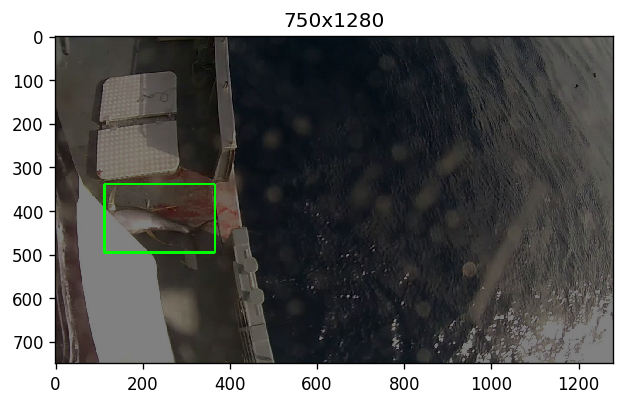

In [15]:
plt.figure(figsize=(6, 6), dpi=120)

example = copy.deepcopy(boxes['yft'][62])
#example = copy.deepcopy(boxes['other'][4])
annotation = example['annotations']
img = cv2.imread(example['filename'], cv2.IMREAD_COLOR)[...,::-1]
img, anot = brightness_image(img , annotation, coef=-0.5)
#img, anot = rotate_image(img , annotation, angle=-1)
example['annotations'] = anot
print(anot)
img = draw_boxes(example,img=img)
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

In [16]:
from random import shuffle
aug_param = {"rotor":[-0.0,-0.0, -0.0, 0.0, 0.0, 0.0],
             'flip':[0,1],
             'left':[10,20,30,40,50],
             'right':[10,20,30,40,50],
             'top':[10,20,30,40,50],
             'bottom':[10,20,30,40,50],
             'bright':[-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]}

def get_gen(type_param):
    if type_param not in  aug_param.keys():
        type_param = 'bright'
    param=  aug_param[type_param]
    def gen(p):
        i=0
        shuffle(p)
        while (True):
            yield p[i]
            i+=1
            if i >= len(p):
                i=0
                shuffle(p)
    return gen(param)          

def get_aug_boxes(boxes):
    aug_boxes = []
    cl = {k: len(v) for k, v in boxes.items()}
    max_cl = max(cl.values())
    
    gen_arr = []
    gen_arr.append(get_gen('bright'))
    gen_arr.append(get_gen('flip'))
    gen_arr.append(get_gen('left'))
    gen_arr.append(get_gen('right'))
    gen_arr.append(get_gen('top'))
    gen_arr.append(get_gen('bottom'))
    gen_arr.append(get_gen('rotor'))
    key_arr = ['bright','flip','left','right','top','bottom','rotor']
    
    
    for k in boxes.keys():
        aug_count = max_cl // cl[k]
        rnd_arr = np.random.choice(7,size=[aug_count,3],p=(0.22,0.22,0.12,0.12,0.12,0.12,0.08))
        for f in range(len(boxes[k])):
            new_aug_box = copy.deepcopy(boxes[k][f])
            new_aug_box['aug'] = {'rotor':0.0}
            new_aug_box['annotations_is_aug'] = False
            aug_boxes.append(new_aug_box)
            for i in range(1,aug_count):
                new_aug_box = copy.deepcopy(boxes[k][f])
                new_aug_box['aug'] = {}
                new_aug_box['aug'][key_arr[rnd_arr[i][0]]]= next(gen_arr[rnd_arr[i][0]])
                new_aug_box['aug'][key_arr[rnd_arr[i][1]]]= next(gen_arr[rnd_arr[i][1]])
                new_aug_box['aug'][key_arr[rnd_arr[i][2]]]= next(gen_arr[rnd_arr[i][2]])
                new_aug_box['annotations_is_aug'] = False
                aug_boxes.append(new_aug_box)
    return aug_boxes             

def iou(rect, x_scale, y_scale, anchor_x, anchor_y, anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union, intersection / anch_square


def cmp_anch(data1, data2):
    return data1[0]/data1[1] < data2[0]/data2[1]


def encode_anchors(annotation, img_shape, iou_thr=0.5):
    #print(ANCHOR_CENTERS)
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 13), dtype=np.float32)
    encoded[:,:,1] = 1.0
    arr_anchor_score = [[()] * int(FEATURE_SHAPE[1]) for i in range(int(FEATURE_SHAPE[0]))]
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    annotation['annotations'] = sorted(annotation['annotations'], key=lambda x: -x['width']*x['height'])
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score, anchor_score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                if anchor_score < 0.0000001:
                    continue
                dist_to_center = -((anchor_x - rect['x']*x_scale)**2+(anchor_y - rect['y']*y_scale)**2)
                scores.append((dist_to_center, anchor_score ,score,  anchor_x, anchor_y, row, col, rect['x'],rect['y'],rect['width'] ,rect['height'], annotation['filename']  ))   
        scores = sorted(scores, reverse=True)
        if len(scores) == 0:
            continue
        score =  scores[0][1]
        #print(score)
        scores = list(filter(lambda x: x[1] > score * iou_thr , scores))
        for i in scores:
           
            if len(arr_anchor_score[i[5]][i[6]]) > 10:
                if cmp_anch(arr_anchor_score[i[5]][i[6]], i):
                    continue
            arr_anchor_score[i[5]][i[6]] = i
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):        
            if len(arr_anchor_score[row][col]) < 11:         
                continue
            dist_to_center, anchor_score , score, anchor_x, anchor_y, _row, _col, r_x, r_y, r_w, r_h, filename = arr_anchor_score[row][col]
            dy = (anchor_y - r_y * y_scale) / ANCHOR_HEIGHT
            dx = (anchor_x - r_x * x_scale) / ANCHOR_WIDTH
            #dw = (ANCHOR_WIDTH * ANCHOR_COEF[num_anc][1] - rect['width'] * x_scale) / ANCHOR_WIDTH
            dw = (ANCHOR_WIDTH - r_w * x_scale) / ANCHOR_WIDTH
            #dh = (ANCHOR_HEIGHT * ANCHOR_COEF[num_anc][0] - rect['height'] * y_scale) / ANCHOR_HEIGHT
            dh = (ANCHOR_HEIGHT - r_h * y_scale) / ANCHOR_HEIGHT
            type_fish = filename.split('/')[-2]
            dict_type = {'NoF': 0.0, 'DOL':0.0, 'SHARK' : 0.0, 'BET' : 0.0, 'LAG': 0.0,'YFT':0.0, 'ALB':0.0, 'OTHER':0.0}
            if type_fish in dict_type:
                dict_type[type_fish] = 1.0
            encoded[row, col] = np.array([1.0] + list(dict_type.values()) +[ dx, dy, dw, dh])
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-1*x))

def decode_prediction(prediction, conf_thr=0.6):
    #print(ANCHOR_CENTERS)
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            *logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(np.array(logit))
            if  conf[0]>conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

In [17]:
aug_boxes = get_aug_boxes(boxes)

### Валидация енкодинга/декодинга

## Функция потерь

In [21]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
   
    conf_loss = K.categorical_crossentropy(y_true[..., 1:9], y_pred[..., 1:9], from_logits=True)
    is_fish_loss = K.binary_crossentropy(y_true[..., 0], y_pred[..., 0],from_logits=True)
    sum_loss = conf_loss + is_fish_loss*0.5
    return sum_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 9:] - y_pred[..., 9:])
    square_loss = 0.5 * K.square(y_true[..., 9:] - y_pred[..., 9:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    # TODO: добавьте функцию потерь для классификации детекции
    y_true = K.reshape(y_true, (batch_size, -1, 13))
    y_pred = K.reshape(y_pred, (batch_size, -1, 13))
     # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * (y_true[..., 0]), axis=-1) 
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    pos_loc_loss = K.sum(loc_loss * (y_true[..., 0]), axis=-1)
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum((y_true[..., 0]), axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1.0-y_true[..., 0]), k=K.cast(num_neg, 'int32'))
    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    full_loss = total_conf_loss + 0.5 * loc_loss
    return full_loss

## Загрузка данных

In [22]:
def load_img(img_data, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    path = img_data['filename']
    
    aug = img_data['aug']
    annotation =  img_data['annotations']
    annot_is_aug = img_data['annotations_is_aug']
    img_raw = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img, annotation  = _resize_image(img_raw,annotation , final_width=target_size[0], final_height=target_size[1],annot_is_aug=annot_is_aug)
    #print('start', img.shape)
    for i in aug:
        if i == 'bright':
            img,annotation = brightness_image(img, annotation, coef=aug[i],annot_is_aug=annot_is_aug)
        if i == 'flip':
            img,annotation = flip_image(img,annotation)
        if i == 'left':
            img,annotation = cropped_image(img, annotation, left=aug[i],annot_is_aug=annot_is_aug)
        if i == 'right':
            img,annotation = cropped_image(img, annotation, rigth=aug[i],annot_is_aug=annot_is_aug)
        if i == 'top':
            img,annotation = cropped_image(img, annotation, top=aug[i],annot_is_aug=annot_is_aug)
        if i == 'bottom':
            img,annotation = cropped_image(img, annotation, bottom=aug[i],annot_is_aug=annot_is_aug)
        if i == 'rotor':
            img,annotation = rotate_image(img, annotation, angle=aug[i],annot_is_aug=annot_is_aug)
    img_data['annotations'] = annotation
    img_data['annotations_is_aug'] = True
    img_shape = img.shape
    return img_shape, keras.applications.vgg16.preprocess_input(img.astype(np.float32))

def data_generator(boxes, batch_size=32):
    while True:
        random.shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j])
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

ex {'annotations': [{'class': 'rect', 'height': 119.00000000000034, 'width': 181.00000000000045, 'x': 917.5000000000023, 'y': 394.50000000000097}], 'class': 'image', 'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/LAG/img_00657.jpg', 'aug': {'left': 40, 'right': 30}, 'annotations_is_aug': False}
ex2 {'annotations': [{'class': 'rect', 'height': 123, 'width': 178, 'x': 869, 'y': 410}], 'class': 'image', 'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/LAG/img_00657.jpg', 'aug': {'left': 40, 'right': 30}, 'annotations_is_aug': True}
aug {'annotations': [{'class': 'rect', 'height': 119.00000000000034, 'width': 181.00000000000045, 'x': 917.5000000000023, 'y': 394.50000000000097}], 'class': 'image', 'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/LAG/img_00657.jpg', 'aug': {'left': 40, 'right': 30}, 'annotations_is_aug': False}
dec 19


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


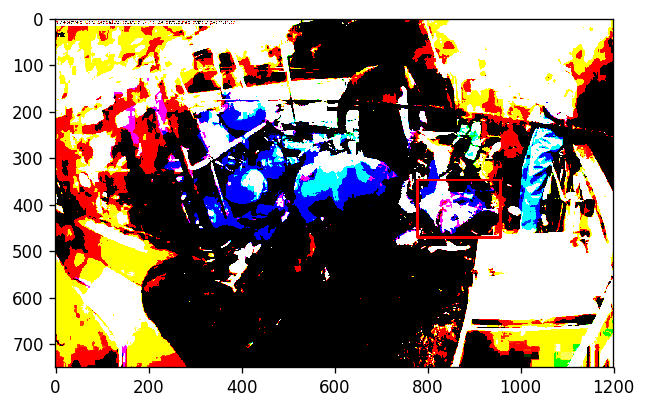

In [23]:
random.shuffle(aug_boxes)
example = copy.deepcopy(aug_boxes[51])
type_fish = example['filename'].split('/')[-2]
print('ex',example)
img_shape, img = load_img(example, target_size=(IMG_WIDTH, IMG_HEIGHT))
print('ex2',example)
print('aug',aug_boxes[51])
encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH))
decoded = decode_prediction(encoded, conf_thr=0.6)
decoded = sorted(decoded, key = lambda e: -e['conf'][0])
decoded = list(filter(lambda x: x['conf'][0]>0.5, decoded))
plt.figure(figsize=(6, 6), dpi=120)

print('dec', len(decoded))
plt.imshow(draw_boxes(example, decoded,(IMG_WIDTH, IMG_HEIGHT), img))

In [24]:
#!ls -la ../input/the-nature-conservancy-fisheries-monitoring/train


In [25]:
#features.summary()

## Добавляем выход детектора

In [26]:
# попытка реализовать u-net

output = keras.layers.Conv2D(1024,kernel_size=(3,3),padding='same')(features.layers[-1].output)
output = keras.layers.Conv2D(1024,kernel_size=(3,3),padding='same')(output)
output = keras.layers.Conv2D(1024,kernel_size=(3,3),padding='same')(output)
output = keras.layers.UpSampling2D(2)(output)
output = keras.layers.ZeroPadding2D(padding=((0,0),(1,0)))(output)
output = keras.layers.Concatenate(axis=-1)([output, features.layers[-2].output])
output = keras.layers.Conv2D(512,kernel_size=(3,3),padding='same')(output)
output = keras.layers.Conv2D(512,kernel_size=(3,3),padding='same')(output)
output = keras.layers.Conv2D(512,kernel_size=(3,3),padding='same')(output)

# как вариант можно  убрать  pooling и после BatchNormalization 
# поставить светочный слой поставить с ядром 2 и смещением 2

output = keras.layers.MaxPool2D(2)(output)
output = keras.layers.BatchNormalization()(output)
#output = keras.layers.BatchNormalization()(features.layers[-1].output)

output = keras.layers.Conv2D(13,
                             kernel_size=(1, 1), 
                             activation='linear',
                             kernel_regularizer='l2')(output)

model = keras.models.Model(inputs=features.inputs, outputs=output)
#model.summary()


## Обучение

In [27]:
adam = keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics={'conf_loss': confidence_loss})

In [28]:
#!ls ../input/result-fish/


In [29]:
# подгружаем имеющиеся веса
#model.load_weights('../input/result-fish/weights.06-0.342.hdf5')


In [30]:
batch_size = 5
steps_per_epoch = int(len(aug_boxes) / batch_size)
gen = data_generator(aug_boxes, batch_size=batch_size)

checkpoint = keras.callbacks.ModelCheckpoint(
    'weights2.{epoch:02d}-{loss:.3f}.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=False, 
    save_weights_only=False,
    mode='auto', period=1)

model.fit_generator(generator=gen, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=1,
                    callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
2498/2499 [============================>.] - ETA: 0s - loss: 0.1364
Epoch 00001: saving model to weights2.01-0.136.hdf5
2499/2499 [==============================] - 1171s 469ms/step - loss: 0.1364


In [31]:
# Фиксируем веса каждой 5 эпохи
checkpoint = keras.callbacks.ModelCheckpoint(
    'weights2.{epoch:02d}-{loss:.3f}.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=False, 
    save_weights_only=False,
    mode='auto', period=5)


model.fit_generator(generator=gen, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=20,
                    callbacks=[checkpoint])

Epoch 1/20
2499/2499 [==============================] - 1157s 463ms/step - loss: 0.2778
Epoch 2/20
2499/2499 [==============================] - 1154s 462ms/step - loss: 0.1638
Epoch 3/20
2499/2499 [==============================] - 1153s 461ms/step - loss: 0.2673
Epoch 4/20
2499/2499 [==============================] - 1154s 462ms/step - loss: 0.2063
Epoch 5/20
2371/2499 [===========================>..] - ETA: 59s - loss: 0.2942

## Результат работы детектора

{'annotations': [{'class': 'rect', 'height': 156, 'width': 237, 'x': 225, 'y': 417}], 'class': 'image', 'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/YFT/img_07340.jpg', 'aug': {}, 'annotations_is_aug': True}
(750, 1200, 3)
(23, 37, 13)
[0.90036136 0.76247615 0.10273828 0.12660654 0.19815329 0.14453582
 0.9990094  0.23599388 0.04928987 0.4953677  0.45699543 0.24822286
 0.33471617]
466.0840316635111 246.02268457009987
[{'x': 238.45477752588894, 'y': 396.70887887477875, 'width': 287.05748319625854, 'height': 183.43507200479507, 'conf': array([0.9886646 , 0.41230747, 0.22852176, 0.08144902, 0.11666101,
       0.25578558, 0.99922764, 0.31339195, 0.07234012], dtype=float32)}, {'x': 242.30644163247703, 'y': 438.77622368543047, 'width': 319.5267677307129, 'height': 198.94736409187317, 'conf': array([0.98219556, 0.52775925, 0.28217927, 0.06454803, 0.18893114,
       0.23154043, 0.99899656, 0.25622284, 0.04801113], dtype=float32)}, {'x': 243.3458988730972, 'y': 413.890

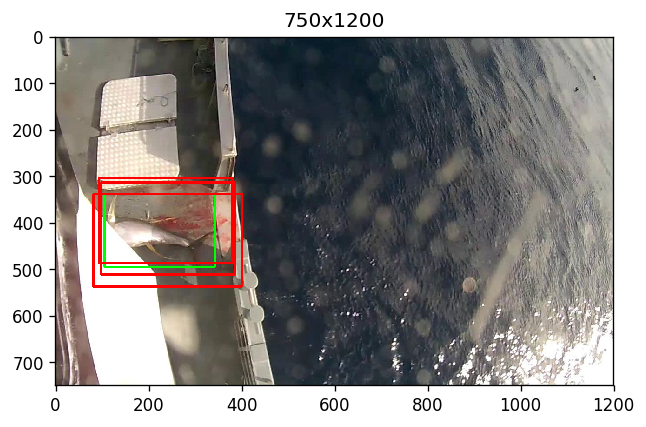

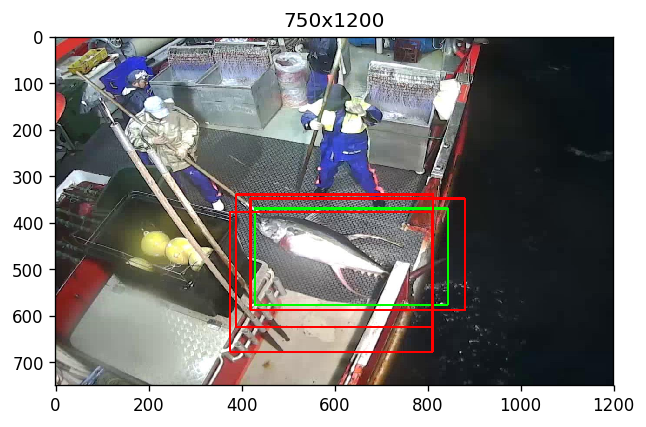

In [32]:
example = boxes['bet'][17]
pred_type_fish = {'dol':2, 'shark' : 3, 'bet' : 4, 'lag':5,'yft':6, 'alb':7}


for i in boxes['yft'][62:64]:
    el = copy.deepcopy(i)
    el['aug'] = {}
    el['annotations_is_aug'] = False
    _, sample_img = load_img(el)
    print(el)
    print(sample_img.shape)
    pred = model.predict(np.array([sample_img,]))[0]
    print(pred.shape)
    print(_sigmoid(pred[13,7]))
    print(ANCHOR_CENTERS[0,13,7]-pred[13,7,10] * ANCHOR_HEIGHT,ANCHOR_CENTERS[1,13,7]- pred[13,7,9] * ANCHOR_WIDTH)
    decoded = decode_prediction(pred, conf_thr=0.4)
    decoded_2 = sorted(decoded, key=lambda e: -e['conf'][0])
    print(decoded_2[:3])
    plt.figure(figsize=(6, 6), dpi=120)
    img_2 = draw_boxes(i, decoded_2[:3], (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img_2)
    plt.title('{}x{}'.format(*img_2.shape));
   

## Агрегация результатов

In [33]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0
#23%100



In [34]:
def pred_draw(img, rectangles, scale_x=1, scale_y=1, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img

def pred_draw_1(img, rectangles, scale_x=1, scale_y=1, color=(0, 255, 0)):
    for rect in rectangles:
        pt1 = (int((rect['x'] - 1) * scale_x),
               int((rect['y'] - 1) * scale_y))
        pt2 = (int((rect['x'] + 1) * scale_x),
               int((rect['y'] + 1) * scale_y))
        img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
    return img   

list_test_predict = []
list_test_predict_st2 = []

In [43]:
import pickle


In [46]:
#!ls ../input/kernel5e182bc5ef/

In [47]:
# Используем несколько вариантов весов для предсказания

fn_l = ['../input/kernel5e182bc5ef/weights2.01-0.136.hdf5','../input/kernel5e182bc5ef/weights2.10-0.304.hdf5','../input/kernel5e182bc5ef/weights2.20-0.331.hdf5']
test_l = ['../input/the-nature-conservancy-fisheries-monitoring/test_stg1/*','../input/2testfish/fish/fish/fish_test/*','../input/2testfish/fish/fish/fish_test2/*']

for i in range(len(fn_l)):
    model.load_weights(fn_l[i])
    for j in range(len(test_l)):
        paths = [path for path in glob(test_l[j])]
        list_test_predict = []
        for path in paths[:]:
            img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
            #dim = (final_width, final_height)
            img_2 = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_AREA)
            pred = model.predict(np.array([img_2,]))[0]
            decoded = decode_prediction(pred, conf_thr=0.4)
            decoded_2 = sorted(decoded, key=lambda e: -e['conf'][0])
            list_test_predict.append((path,decoded_2))
        with open(f'predict_data_st_{j}.pickle', 'wb') as f:
            pickle.dump(list_test_predict, f)    

In [49]:
import cv2
import pickle 

dict_test_predict = {}


for i in range(3):
    for j in range(3):
        with open(f'predict_data_st{i}_{j}.pickle', 'rb') as f:
            tmp_list = pickle.load(f)
        for path, pred in tmp_list:
            if path not in dict_test_predict.keys():
                dict_test_predict[path] = []
            dict_test_predict[path] = dict_test_predict[path] + pred   
            
 
print(len(dict_test_predict))

13153


38
0
0
18
57


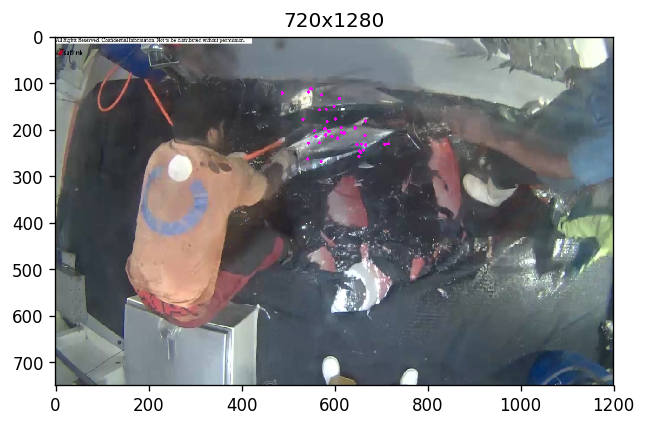

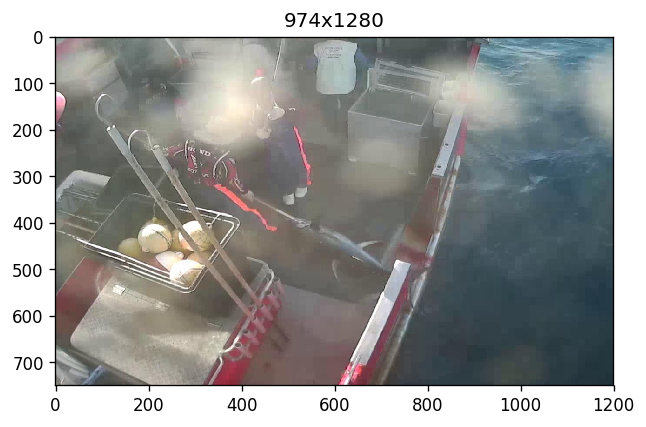

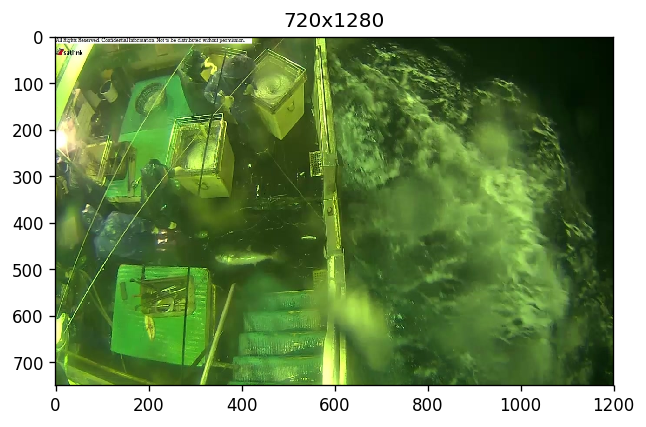

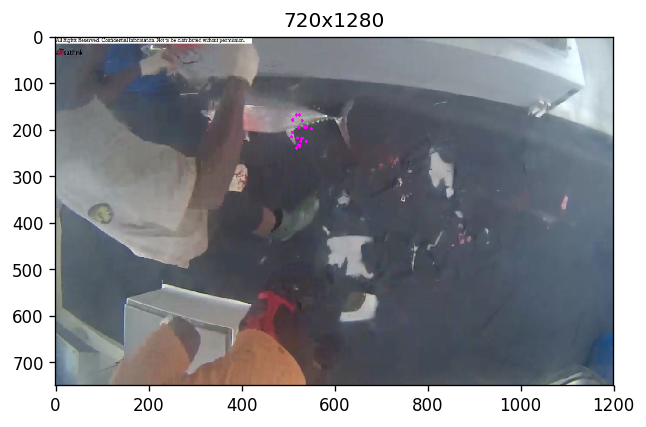

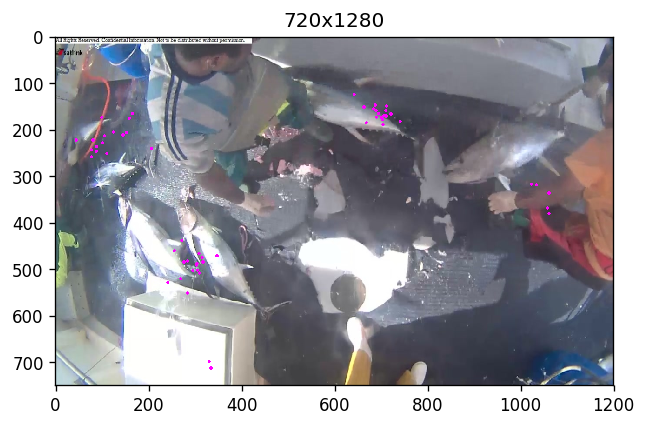

In [50]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

lust_path_pred = list(dict_test_predict.keys())
for path in lust_path_pred[15:20]:
    pred = dict_test_predict[path]
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_2 = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_AREA)
    print(len(pred))
    img_3 = pred_draw_1(img_2, pred, color=(255,0,255))
    plt.figure(figsize=(6, 6), dpi=120)
    plt.imshow(img_3)
    plt.title('{}x{}'.format(*img.shape));

In [51]:
#from sklearn.mixture import GaussianMixture
#cls = GaussianMixture(n_components=2)
#lust_path_pred = list(dict_test_predict.keys())
#res = []
#for path in lust_path_pred[11829:11833]:
#    X = []
#    pred = dict_test_predict[path]
#    X = ([[el['x'],el['y']] for el in pred])
#    res = cls.fit_predict(X)
#    print(res)


In [52]:
# предсказанные результаты объеденим в кластеры

def pred_draw_11(img, rectangles, res_color=[0],  scale_x=1, scale_y=1, color=[(0, 255, 0)]):
    for i, rect in enumerate(rectangles):
        
        pt1 = (int((rect['x'] - 1) * scale_x),
               int((rect['y'] - 1) * scale_y))
        pt2 = (int((rect['x'] + 1) * scale_x),
               int((rect['y'] + 1) * scale_y))
        num_clr = res_color[i] if i < len(res_color) else res_color[-1] 
        clr = color[num_clr] if num_clr < len(color) else color[-1]
        img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=clr, thickness=4)
    return img  

from sklearn.mixture import GaussianMixture
cls = GaussianMixture(n_components=4)


from sklearn.cluster import DBSCAN
dbs = DBSCAN(min_samples=1, eps=50)

dict_test_final_predict = {}
lust_path_pred = list(dict_test_predict.keys())
for path in lust_path_pred:
    pred = dict_test_predict[path]
    X = ([[el['x'],el['y']] for el in pred])
    #cur_cls = cls.fit(X)
    if len(X) > 0:
        cur_cls = dbs.fit(X)
    #else:
    #    cur_cls.labels_ = []
        
    #print(cur_cls.labels_)
    claster_pred = {}
    for i in range(len(pred)):
        cur_key = cur_cls.labels_[i]
        if cur_key in claster_pred.keys():
            claster_pred[cur_key].append(pred[i])
        else: 
            claster_pred[cur_key] = [pred[i]]
        
    claster_pred_fin = {}   
    for i in claster_pred.keys():
        
        data_box, data_conf=[],[]
        for p in claster_pred[i]:
            data_box.append([p['x'],p['y'],p['width'],p['height']])
            data_conf.append(list(p['conf']))
        #print(np.array(data_box).shape)
        #print(np.array(data_conf).shape)
        data = np.concatenate((np.array(data_box),np.array(data_conf)),axis=1)    
        data = np.array(list(filter(lambda x: x[0] > 0.5, list(data))))
        if data.shape[0] > 0:
            #print(data.shape)               
            data_box = np.average(np.array(data[:,:5]),axis=0)
            data_conf = np.amax(np.array(data[:,5:]),axis=0)
            claster_pred_fin[i] = np.concatenate((data_box,data_conf),axis=0)
          
    #print(claster_pred)
    dict_test_final_predict[path] = claster_pred_fin
    
    
#print(dict_test_final_predict)
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


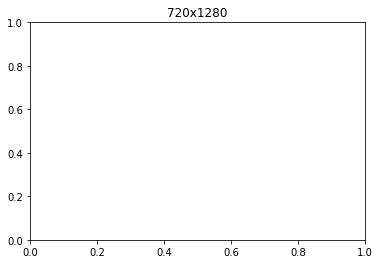

In [54]:
# получим предсказания

def pred_draw_2(img, cls_pred, scale_x=1, scale_y=1, color=[(0, 255, 0)]):
    for cl in cls_pred.keys():
        #print(cls_pred[cl])
        pt1 = (int((cls_pred[cl][0] - cls_pred[cl][2]/2) * scale_x),
               int((cls_pred[cl][1] - cls_pred[cl][3]/2) * scale_y))
        pt2 = (int((cls_pred[cl][0] + cls_pred[cl][2]/2) * scale_x),
               int((cls_pred[cl][1] + cls_pred[cl][3]/2) * scale_y))
        clr = color[int(cl)] if int(cl) < len(color) else color[-1]
        img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=clr, thickness=4)
    return img  

#            6      7        8       9       10      11      12             5
#           DOL'  'SHARK'  'BET'   'LAG'   'YFT'    'ALB'   OTHER          NoF
# image 	ALB 	BET 	DOL 	LAG 	NoF 	OTHER 	SHARK 	YFT
#            1       2       3       4       5        6       7      8
#     6 -> 3 ,   7 -> 7,  8 -> 2, 9 -> 4, 10 -> 8, 11 -> 1, 12 -> 6     5 -> 5

result = []

for path in list(dict_test_final_predict.keys())[15:22]:
    pred = dict_test_final_predict[path]
    filter_pred = {}
    
    for key in pred.keys():
        if max(pred[key][6:13]) > 0.2:
            filter_pred[key] = pred[key]
    
    
    filter_pred_list = []
    for key in filter_pred.keys():
        filter_pred_list.append(filter_pred[key])
        
    list_tmp = np.array(filter_pred_list)
    
    res = [0,0,0,0,0,0,0,0]
    if list_tmp.shape[0] < 1:
        result.append((path, [1,0,0,0,0,0,0,0]))
    else:
        #print(list_tmp)
        for i in range(1,9):
            if max(list_tmp[:,5+i:5+i+1]) > 0.9:
                res[i] +=1 
        if sum(res) > 0: 
            if sum(res) == max(res):
                result.append((path, res))
            else:
                tmp_arr = np.array(res) *  (np.amax(list_tmp[:,5:],axis=0)-0.5)**20
                result.append((path, list(tmp_arr/np.sum(tmp_arr)) ))
        else:
            for i in range(1,9):
                if  0.8 < max(list_tmp[:,5+i:5+i+1]) < 0.9:
                    res[i] +=1
            if sum(res) > 0:         
                tmp_arr = np.array(res) *  np.amax(list_tmp[:,5:],axis=0)
                tmp_arr[-1] =  1- np.amax(tmp_arr)
                result.append((path, list(tmp_arr/np.sum(tmp_arr)) )) 
            else:
                for i in range(1,9):
                    if  0.5 < max(list_tmp[:,5+i:5+i+1]) < 0.8:
                        res[i] +=1
                if sum(res) > 0:         
                    tmp_arr = np.array(res) *  (np.amax(list_tmp[:,5:],axis=0))
                    tmp_arr[-1] =  np.amax(tmp_arr)
                    tmp_arr[0] = 1-np.amax(tmp_arr)
                    result.append((path, list(tmp_arr/np.sum(tmp_arr)) )) 
                else:
                    result.append((path, [1,0,0,0,0,0,0,0]))
    
    plt.title('{}x{}'.format(*img.shape));


In [55]:
result2 = []

for path in list(dict_test_final_predict.keys()):
    pred = dict_test_final_predict[path]
    #print('pred',pred)
    #img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    #img_2 = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_AREA)
    
    filter_pred = {}
    
    for key in pred.keys():
        if max(pred[key][6:13]) > 0.2:
            filter_pred[key] = pred[key]
    #print(filter_pred)
    
    filter_pred_list = []
    for key in filter_pred.keys():
        filter_pred_list.append(filter_pred[key])
        
    list_tmp = np.array(filter_pred_list)
    
    res = np.array([0,0,0,0,0,0,0,0])
    if list_tmp.shape[0] < 1:
        result2.append((path, [1,0,0,0,0,0,0,0]))
    else:
        #print(list_tmp)
        max_pred = np.amax(list_tmp[:,5:])
        for i in range(1,9):
            if max(list_tmp[:,5+i:5+i+1]) >= max_pred:
                res[i] = 1.0
        if max_pred >0.9 :
                result2.append((path, list(res)))
        else:
            if 0.8 < max_pred <=0.9 :
                res = res * max_pred
                res[-1] = 1.0 - max_pred
                result2.append((path, list(res)))
            else:
                if 0.5 < max_pred <=0.8 :
                    res = res * max_pred
                    res[-1] = (1.0 - max_pred)/2.0
                    res[0] =(1.0 - max_pred)/2.0
                    result2.append((path, list(res)))
                else:
                    result2.append((path, [1,0,0,0,0,0,0,0]))
            
            

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [56]:
len(dict_test_final_predict.keys())

13153

In [57]:
len(result2)

13153

In [58]:
# Сформируем файл для сабмита

#            5       6      7        8       9       10      11      12             
#           NoF     DOL'  'SHARK'  'BET'   'LAG'   'YFT'    'ALB'   OTHER         
# image 	ALB 	BET 	DOL 	LAG 	NoF 	OTHER 	SHARK 	YFT
#            1       2       3       4       5        6       7      8
#     6 -> 3 ,   7 -> 7,  8 -> 2, 9 -> 4, 10 -> 8, 11 -> 1, 12 -> 6   5 -> 5
#     1          2        3       4       5         6        7        0 

result_to_file = []
for i in range(len(result)):
    fn, res = result[i]
    fn_to_file = fn.split('/')[-1] if i < 1000 else 'test_stg2/'+fn.split('/')[-1]
    result_to_file.append([fn_to_file, res[6],res[3],res[1],res[4],res[0],res[7],res[2],res[5]])
    
result2_to_file = []
for i in range(len(result2)):
    fn, res = result2[i]
    fn_to_file = fn.split('/')[-1] if i < 1000 else 'test_stg2/'+fn.split('/')[-1]
    result2_to_file.append([fn_to_file, res[6],res[3],res[1],res[4],res[0],res[7],res[2],res[5]])   

In [59]:
df_to_file = pd.DataFrame(result_to_file, columns=['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK','YFT'])

In [60]:
df_to_file.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_04482.jpg,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,img_00152.jpg,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000
2,img_04640.jpg,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000
3,img_02367.jpg,0.835431,0.000000,0.0,0.0,0.0,0.0,0.0,0.164569
4,img_05805.jpg,0.607078,0.024536,0.0,0.0,0.0,0.0,0.0,0.368386


In [61]:
df_to_file.to_csv('submit_fish.csv', header=True, index=False)

In [62]:
#!cat submit_fish.csv 

In [63]:
df_to_file = pd.DataFrame(result2_to_file, columns=['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK','YFT'])

In [64]:
df_to_file.to_csv('submit_fish2.csv', header=True, index=False)

In [65]:
#!cat submit_fish2.csv 

# Результат

### С результатами все печально (результат модели получет до обнаружения примеров отстутствующих и других рыбок )

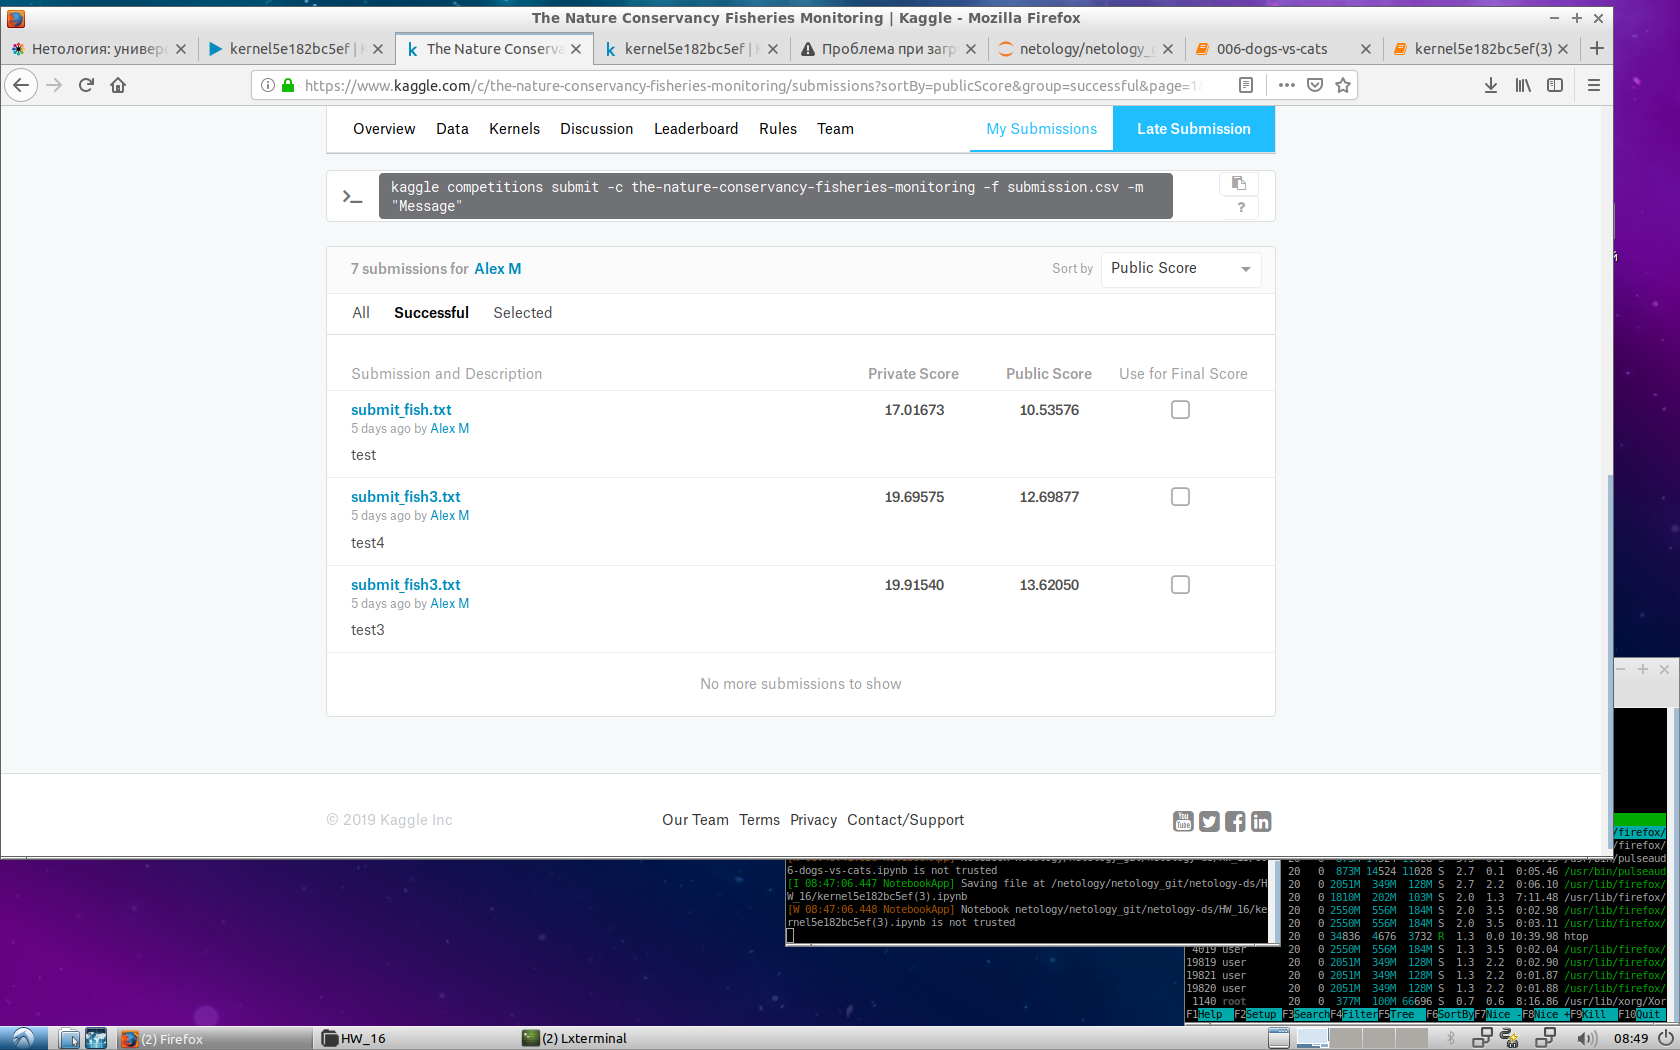

In [3]:
from IPython.display import Image
Image("all-commit.png")